### Original user features

In [2]:
import pandas as pd
import numpy as np
dfull=pd.read_csv(header=0,sep=",",filepath_or_buffer="/datastore/complexnet/jlevyabi/geoloc/txt_files/usr_info/ses_ling_french_info.csv")
dfull=dfull.drop(dfull.columns[0],axis=1)
dfull.head()

,usr,lon,lat,income,owner_ratio,density,nr,nbn,plur_rate,nb_plurs,wss
0,416977731,-1.66,48.10,19895.671480,0.339,6925.000,0.057143,34,0.933333,30,2.65726
1,718421760,0.08,48.27,18886.873563,0.207,98.864,0.666667,3,0.000000,1,4.90000
2,73846001,6.09,46.13,24771.782609,0.304,143.750,0.750000,4,0.600000,5,3.30137
3,1944739136,-3.21,47.36,22926.558824,0.235,425.000,0.333333,8,1.000000,3,7.42857
4,1004055811,2.40,48.78,13835.925520,0.064,54712.500,0.200000,5,1.000000,3,4.44118


# Raw Locations

In [2]:
dfloc=pd.read_csv('/datastore/complexnet/jlevyabi/geoloc/txt_files/usr_info/loc_all_users.csv',sep=',')
dfloc=dfloc.drop([dfloc.columns[0],dfloc.columns[2],dfloc.columns[3],dfloc.columns[0]],axis=1,)
dfloc.head()

,usr,nb_loc
0,1678751485,1
1,335266146,1
2,452639510,1
3,416977731,1
4,718421760,2


#  Locations

In [3]:
full_with_loc=pd.merge(dfull, dfloc, on='usr')
full_with_loc=full_with_loc[full_with_loc.nb_loc>50]
data=[]
with open('/datastore/complexnet/jlevyabi/ml_soc_econ/data_files/text_ses_net_approach/incomed_sure_tweets.txt','r') as f:
    for line in f.readlines():
        info=line.split()
        data.append((info[0]," ".join(info[1:])))
tweets_df=pd.DataFrame(data=data,columns=["usr","body"])
tweets_df.head()

,usr,body
0,1011642565,dans deux semaine on a un chiot👌🐶🐶
1,1011642565,dans mon lycee y a mon ancien prof de phisique...
2,1011642565,demain j dois me lever a h pour aller debloque...
3,1011642565,demain je suis censee avoir anglais math et fr...
4,1011642565,demain lets go camping avec les gros


In [3]:
df_inc=pd.read_csv('/datastore/complexnet/jlevyabi/ml_soc_econ/data_files/text_ses_net_approach/incomed_sure_usrs.csv',sep=";",header=0)
df_inc.head()

,usr,lon,lat,income,owner_ratio,density,nr,nbn,plur_rate,nb_plurs,wss,nb_loc
0,478734242,6.25,45.99,23003.052632,0.303,475.00,0.144231,102,0.902439,79,2.31469,114
1,2324384035,4.43,43.82,17387.197183,0.211,443.75,0.203125,62,0.875000,61,2.51374,88
2,242434799,5.99,49.40,18418.941177,0.382,212.50,0.351351,36,0.866667,43,3.59859,61
3,2158770817,1.95,49.63,17549.247059,0.318,531.25,0.121951,120,0.866667,147,2.45521,77
4,1854461138,2.86,47.49,21918.972222,0.167,180.00,0.220000,192,0.880342,111,1.78607,83


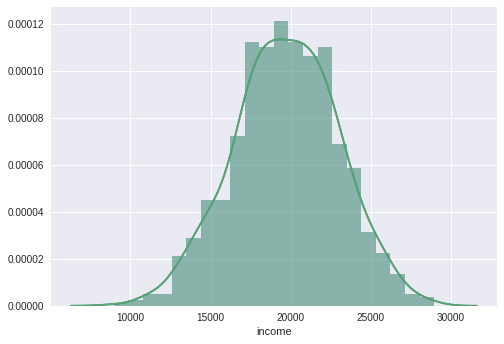

In [5]:
import seaborn as sns
sns.distplot(df_inc.income)
sns.plt.show()

# Get tweets for users with more than x locations

In [ ]:
#!/usr/bin/env python
#encoding: utf-8
#Get tweets from geousers active enogh
import tweepy #https://github.com/tweepy/tweepy
import csv
from tqdm import tqdm
import re
#Twitter API credentials
consumer_key = "G6LrnHdGQcW7hZGsSQRT1gnkQ"
consumer_secret = "ewUYjRO7rZC1l97HZHRy8Pt9AkzfqY2YXRk10xUqWMAnQU47D0"
access_key = "836532209322508289-1xr3ZxA4ObClD0Ixx2a81MwnF2dR4da"
access_secret = "G9rx8oMPreqRYK6JwLIJ7XlBHz2Ute1Jc54YrOm4oI6Rs"

def get_all_tweets(user_id):
	#Twitter only allows access to a users most recent 3240 tweets with this method
	#authorize twitter, initialize tweepy
	auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
	auth.set_access_token(access_key, access_secret)
	api = tweepy.API(auth)
	#initialize a list to hold all the tweepy Tweets
	alltweets = []	
	#make initial request for most recent tweets (200 is the maximum allowed count)
	new_tweets = api.user_timeline(user_id = user_id,count=200)
	#save most recent tweets
	alltweets.extend(new_tweets)
	#save the id of the oldest tweet less one
	oldest = alltweets[-1].id - 1;print ("getting tweets before %s" % (oldest))
	#keep grabbing tweets until there are no tweets left to grab
	while len(new_tweets) > 0:
		#all subsiquent requests use the max_id param to prevent duplicates
		new_tweets = api.user_timeline(user_id = user_id,count=200,max_id=oldest)
		#save most recent tweets
		alltweets.extend(new_tweets)
		#update the id of the oldest tweet less one
		oldest = alltweets[-1].id - 1
	cleaned_text = [re.sub(r'http[s]?:\/\/.*[\W]*', '', i.text, flags=re.MULTILINE) for i in alltweets] # remove urls
	cleaned_text = [re.sub(r'@[\w]*', '', i, flags=re.MULTILINE) for i in cleaned_text] # remove the @twitter mentions 
	cleaned_text = [re.sub(r'RT.*','', i, flags=re.MULTILINE) for i in cleaned_text] # delete the retweets
	#transform the tweepy tweets into a 2D array that will populate the csv	
	outtweets = [[tweet.id_str, tweet.created_at, cleaned_text[idx].encode("utf-8")] for idx,tweet in enumerate(alltweets)]
	#transform the tweepy tweets into a 2D array that will populate the csv	
	#outtweets = [[tweet.id_str, tweet.created_at, tweet.text] for tweet in alltweets]
	#write the csv	
	with open('/datastore/complexnet/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/tweets/individual_files/%s_tweets.csv'%user_id, 'w') as f:
		writer = csv.writer(f)
		writer.writerow(["id","created_at","text"])
		writer.writerows(outtweets)
	return(True)

if __name__ == '__main__':
	for idx in tqdm(geo_usrs):
		success=False
		while not success:
			try:
				success=get_all_tweets(idx)
			except:
				continue

In [68]:
tweets_df=pd.read_csv(open('/datastore/complexnet/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/tweets/full_incomed_usrs.tsv','rU'),header=None, encoding='utf-8',sep='\t',engine='c')
tweets_df.columns = ['usr', 'body']
tweets_df.head()

/home/jlevyabi/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: 'U' mode is deprecated
  if __name__ == '__main__':


,usr,body
0,100736410,a activites gratuites a faire...
1,100736410,a activites insolites a decouvrir ...
2,100736410,a bien de quoi ouvrir ce weekend la preuv...
3,100736410,accueille le challenge pistenbully sorte...
4,100736410,a chacun sa pause dejeuner sublicimes vikin...


# Tweets + features for certain users

In [69]:
tweets_df['usr']=tweets_df['usr'].apply(lambda x: str(x))
df_inc['usr']=df_inc['usr'].apply(lambda x: str(x))
all_tw_df=pd.merge(tweets_df, df_inc, on='usr')
all_tw_df['body']=all_tw_df['body'].apply(lambda x: str(" ".join(x.split())))
all_tw_df.head()

,usr,body,lon,lat,income,owner_ratio,density,nr,nbn,plur_rate,nb_plurs,wss,nb_loc
0,100736410,a activites gratuites a faire cet ete a la mon...,6.06,45.5,14554.381579,0.079,1900.0,0.5,6,0.891892,37,4.21138,51
1,100736410,a activites insolites a decouvrir cet ete a la...,6.06,45.5,14554.381579,0.079,1900.0,0.5,6,0.891892,37,4.21138,51
2,100736410,a bien de quoi ouvrir ce weekend la preuve en ...,6.06,45.5,14554.381579,0.079,1900.0,0.5,6,0.891892,37,4.21138,51
3,100736410,accueille le challenge pistenbully sorte de ch...,6.06,45.5,14554.381579,0.079,1900.0,0.5,6,0.891892,37,4.21138,51
4,100736410,a chacun sa pause dejeuner sublicimes viking,6.06,45.5,14554.381579,0.079,1900.0,0.5,6,0.891892,37,4.21138,51


In [65]:
#tryo=(all_tw_df.groupby('usr',squeeze=True,)['body'].apply(lambda x: "%s" % ', '.join(x))).to_frame()
#tryo['usr'] = tryo.index
#user_info=pd.merge(tryo, df_inc, on='usr')
#user_info.head()
#user_info.to_csv('everything_for_incomed_users.csv',header=True,index=None,sep='\t')
user_info=pd.read_csv('/datastore/complexnet/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/tweets/everything_for_incomed_users.csv',sep="\t",header=0)
user_info.head()

,body,usr,lon,lat,income,owner_ratio,density,nr,nbn,plur_rate,nb_plurs,wss,nb_loc
0,a activites gratuites a faire cet ete a la mon...,100736410,6.06,45.50,14554.381579,0.079,1900.000,0.500000,6,0.891892,37,4.21138,51
1,"ah bah ça oui😌, ah bah enfin j ai mon bac ment...",1011642565,-3.26,47.84,16634.038462,0.231,1300.000,0.105263,38,0.727273,41,3.92965,58
2,a chaque fois que je m engueule avec une perso...,1014674024,-0.63,44.90,21772.835821,0.269,279.167,0.242424,31,0.916667,34,3.77976,81
3,"aaah bah non lt nintendoswitch, aaahhhh dommag...",101564968,0.92,47.58,16877.611111,0.259,675.000,0.329545,83,0.887500,79,2.83564,81
4,a ans marie tient toujours l epicerie de ses g...,101798538,3.07,45.77,24474.747100,0.353,5387.500,0.454545,10,0.938776,49,4.44041,62


# Bill Vasileios method

## Consider behaviour, impact, profile description

In [8]:
import tweepy #https://github.com/tweepy/tweepy
import csv
from tqdm import tqdm
consumer_key = "G6LrnHdGQcW7hZGsSQRT1gnkQ"
consumer_secret = "ewUYjRO7rZC1l97HZHRy8Pt9AkzfqY2YXRk10xUqWMAnQU47D0"
access_key = "836532209322508289-1xr3ZxA4ObClD0Ixx2a81MwnF2dR4da"
access_secret = "G9rx8oMPreqRYK6JwLIJ7XlBHz2Ute1Jc54YrOm4oI6Rs"

In [9]:
def get_additional_feats(user_id):
	auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
	auth.set_access_token(access_key, access_secret)
	api = tweepy.API(auth)
	#Twitter only allows access to a users most recent 3240 tweets with this method
	#authorize twitter, initialize tweepy
	auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
	auth.set_access_token(access_key, access_secret)
	api = tweepy.API(auth,parser=tweepy.parsers.JSONParser())
	#initialize a list to hold all the tweepy Tweets
	usr_info=api.get_user(user_id);usr_info_dic={'followers_count':test['followers_count'],
                                                 'friends_count':test['followers_count'],
                                                 'favourites_count':test['favourites_count'],
                                                 'listed_count':test["listed_count"],
                                                 'description':test['description']}
	return(usr_info_dic)

In [10]:
add_feats=[];passed=0
for usr in tqdm(df_inc.usr):
    try:
        add_feats.append(get_additional_feats(usr))
    except:
        passed+=1
print(passed)

100%|██████████| 882/882 [05:38<00:00,  2.65it/s]

882


Missing (TODO): Vasileios Impact score+ behaviour features

## Topics of discussion: Spectral Clustering

Therefore, we were obliged to use the skip-gram (word2vec) model with negative sampling to learn word embeddings on a held-out Twitter reference corpus (an amazing implementation can be found in the gensim library). This time we replaced the NPMI metric with a cosine similarity between all pairs of word embeddings. Similarly with the previous approach, we then applied spectral clustering on the derived word-by-word neural-cosine similarity matrix.

In [10]:
import gensim.models.word2vec as w2v
from gensim.models import Word2Vec
from gensim.similarities import MatrixSimilarity
from gensim.matutils import Dense2Corpus
from scipy import sparse
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import gensim
from tqdm import tqdm

Using TensorFlow backend.


In [11]:
model = Word2Vec.load('/home/jlevyabi/seacabo/data_files/lowe_dim_sosweet2vec.w2v')

In [12]:
model.most_similar('mcdo',topn=10)

[('macdo', 0.9883631467819214),
 ('domac', 0.9345623850822449),
 ('kfc', 0.9239674210548401),
 ('kebab', 0.915961503982544),
 ('resto', 0.8945638537406921),
 ('restau', 0.8943831324577332),
 ('tacos', 0.8794286251068115),
 ('grec', 0.8672162294387817),
 ('flunch', 0.8589569330215454),
 ('otacos', 0.8397942185401917)]

In [13]:
import unicodedata
def after_treatment_word2vec(w2v_model,min_times):
    treated_words=[]
    for word in w2v_model.wv.vocab:
        #wrd_uni_data=unicodedata.normalize("NFKD",word)
        alpha_wrds=''.join(x for x in word if x.isalpha())
        if len(alpha_wrds)==len(word) and w2v_model.wv.vocab[word].count>min_times:
            treated_words.append(word)
    return treated_words

In [26]:
vocab = after_treatment_word2vec(model,min_times=50)
print(len(vocab))

249


In [27]:
modelvect = model[vocab]
A_sparse = sparse.csr_matrix(np.array([gensim.matutils.unitvec(i) for i in tqdm(modelvect)]))

100%|██████████| 249/249 [00:00<00:00, 16604.11it/s]


In [59]:
similarities =np.matrix(cosine_similarity(A_sparse,dense_output=True))
threshold_for_bug = 0.00000001 # could be any value, ex numpy.min
similarities[similarities < threshold_for_bug] = threshold_for_bug

In [60]:
nb_clusts=20
from sklearn.cluster import spectral_clustering,SpectralClustering
import numpy as np
spectral = SpectralClustering(n_clusters=nb_clusts, eigen_solver='arpack',affinity="precomputed",n_jobs=20)
labels=spectral.fit_predict(similarities)

In [ ]:
word_clusters={i:[] for i in range(nb_clusts)}
for it,lab in enumerate(labels):
    word_clusters[lab].append(vocab[it])

In [ ]:
import matplotlib.pyplot as plt
plt.bar(range(nb_clusts),[len(val) for val in list(word_clusters.values())])
plt.xlabel('Cluster')
plt.ylabel('Nb Words')
plt.show()

In [10]:
vocab[97] #politique

matrix([[ 0.37483208,  1.        ,  0.50587318,  0.46545476,  0.17839671,
          0.3347546 , -0.14800871,  0.57142611,  0.35963204,  0.20808213,
          0.1712922 ,  0.50067831,  0.15276342,  0.05026596, -0.21986993,
          0.18281049,  0.08083548, -0.25193438,  0.54680915,  0.22221932,
          0.39110924, -0.18573718, -0.11098607, -0.09828109, -0.0632073 ,
         -0.24187552,  0.07628923,  0.04751756, -0.1474309 ,  0.22754431,
         -0.08829775,  0.01414412,  0.15552257,  0.20246416,  0.14265284,
          0.12087706,  0.07054293,  0.31676048,  0.2498109 ,  0.05771231,
         -0.06760405,  0.36429014,  0.03659693,  0.29661111,  0.29457758,
          0.19990077, -0.17366021,  0.46611614,  0.12465675, -0.18078202]])

In [19]:
word_clusters[99]# foot

['clause',
 'silva',
 'genesio',
 'mbappe',
 'lukaku',
 'motta',
 'wenger',
 'aguero',
 'costa',
 'benfica',
 'sergio',
 'jese',
 'sissoko',
 'decisif',
 'defenseur',
 'torres',
 'luiz',
 'luis',
 'paradiseisland',
 'liverpool',
 'edf',
 'reus',
 'olbes',
 'courtois',
 'gourcuff',
 'pl',
 'draxler',
 'rabiot',
 'juventus',
 'buffon',
 'offensif',
 'sakho',
 'zizou',
 'lopes',
 'lopez',
 'fcbrma',
 'hazard',
 'city',
 'teampsg',
 'mane',
 'lacazette',
 'barca',
 'teamom',
 'besiktas',
 'porto',
 'aurier',
 'ballon',
 'poteau',
 'rclens',
 'drogba',
 'ham',
 'yaya',
 'alves',
 'falcao',
 'maria',
 'marco',
 'guingamp',
 'bastia',
 'banc',
 'ozil',
 'mahrez',
 'mendy',
 'umtiti',
 'mandanda',
 'rodriguez',
 'monaco',
 'mourinho',
 'zaza',
 'isco',
 'transfert',
 'buteur',
 'msn',
 'peno',
 'guardiola',
 'ol',
 'penalty',
 'united',
 'moussa',
 'cristiano',
 'nabil',
 'chelsea',
 'diego',
 'griezmann',
 'tolisso',
 'pogba',
 'coach',
 'gardien',
 'lens',
 'valbuena',
 'madrid',
 'deschamps

In [82]:
import pickle
#phrunch_clusters=pickle.load(open('/home/jlevyabi/seacabo/data_files/spec_clusters.p','rb'))
with open('/home/jlevyabi/seacabo/data_files/spec_clusters.p', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'utf-8'
    phrunch_clusters = u.load()

In [135]:
word2cluster={word:cluster_nb for cluster_nb,cluster_words in phrunch_clusters.items() for word in cluster_words}
len(word2cluster)

42883

In [143]:
from collections import Counter
from tqdm import tqdm
all_tw_df.head()
clust_freq=[]
for tw in (user_info.body):
    clust_freq.append((Counter([word2cluster[word] for word in tw.split() if word in word2cluster ])))

## Cluster frequency distribution(CFD) v1: Normalization per user

In [173]:
pre_cfd_v1=[{k:(v+0.0)/(sum(dic_count.values()))for k,v in dic_count.items()} for dic_count in clust_freq]
user_info["cfd_v1"]=[np.array(list({clus:(dic_count[clus] if clus in dic_count else 0) 
                           for clus in range(len(phrunch_clusters))}.values())) for dic_count in pre_cfd_v1]

In [174]:
user_info.head()

,body,usr,lon,lat,income,owner_ratio,density,nr,nbn,plur_rate,nb_plurs,wss,nb_loc,cfd_v1
0,a activites gratuites a faire cet ete a la mon...,100736410,6.06,45.50,14554.381579,0.079,1900.000,0.500000,6,0.891892,37,4.21138,51,"[0.0142927753522, 0.00387181810693, 0.00247137..."
1,"ah bah ça oui😌, ah bah enfin j ai mon bac ment...",1011642565,-3.26,47.84,16634.038462,0.231,1300.000,0.105263,38,0.727273,41,3.92965,58,"[0.0103916866507, 0.000799360511591, 0.0, 0.00..."
2,a chaque fois que je m engueule avec une perso...,1014674024,-0.63,44.90,21772.835821,0.269,279.167,0.242424,31,0.916667,34,3.77976,81,"[0.0126345580432, 0.00151614696518, 0.00267852..."
3,"aaah bah non lt nintendoswitch, aaahhhh dommag...",101564968,0.92,47.58,16877.611111,0.259,675.000,0.329545,83,0.887500,79,2.83564,81,"[0.0160372093023, 0.0016, 0.0151069767442, 0.0..."
4,a ans marie tient toujours l epicerie de ses g...,101798538,3.07,45.77,24474.747100,0.353,5387.500,0.454545,10,0.938776,49,4.44041,62,"[0.0339276441059, 0.00578154751601, 0.00252726..."


Test: Cluster distribution against income

In [254]:
feats=np.vstack((user_info.cfd_v1).values)
target=user_info.income.values

sorted_target=np.sort(target)
nb_class=3
target_bins=[sorted_target[i*int(len(sorted_target)/nb_class)] for i in range(nb_class)]
target_bins.append(max(sorted_target)+1)
target_class=np.digitize(target,target_bins)

In [255]:
from sklearn.linear_model import Ridge 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_error,explained_variance_score

X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size=0.2, random_state=1)

my_ridge_unorm_reg=Ridge(normalize=False,random_state=1)
my_ridge_unorm_reg.fit(X_train,y_train)
pred_unorm=my_ridge_unorm.predict(X_test)
print("Regression Unorm...",explained_variance_score(y_test, pred_unorm),
      r2_score(y_test, pred_unorm),mean_absolute_error(y_test, pred_unorm))
my_ridge_norm_reg=Ridge(normalize=True,random_state=1)
my_ridge_norm_reg.fit(X_train,y_train)
pred_norm=my_ridge_norm.predict(X_test)
print("Regression Norm...",explained_variance_score(y_test, pred_norm),
      r2_score(y_test, pred_norm),mean_absolute_error(y_test, pred_norm))

Regression Unorm... -1.5753565874e-07 -36.171899006 19674.3039825
Regression Norm... 1.35723617012e-07 -36.1719136593 19674.3080473


In [256]:
from sklearn.linear_model import RidgeClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss,accuracy_score,f1_score

print(Counter(target_class),"No need for class_weights...")
X_train, X_test, y_train, y_test = train_test_split(feats, target_class, test_size=0.2, random_state=1)

my_ridge_unorm_class=RidgeClassifier(normalize=False,random_state=1)
my_ridge_unorm_class.fit(X_train,y_train)
pred_unorm=my_ridge_unorm_class.predict(X_test)
print("Classification Unorm...",accuracy_score(y_test, pred_unorm),
      f1_score(y_test, pred_unorm,average='macro'))

my_ridge_norm_class=RidgeClassifier(normalize=True,random_state=1)
my_ridge_norm_class.fit(X_train,y_train)
pred_norm=my_ridge_norm_class.predict(X_test)
print("Classification Norm...",accuracy_score(y_test, pred_norm),
      f1_score(y_test, pred_norm,average='macro'))


Counter({3: 249, 1: 246, 2: 245}) No need for class_weights...
Classification Unorm... 0.297297297297 0.252028466823
Classification Norm... 0.378378378378 0.377591450536


In [280]:
for it,clusters_coef in enumerate(my_ridge_unorm_class.coef_):
    print ("Class %d most associated with clusters %s"%(it+1,"-".join(map(str,clusters_coef.argsort()[-5:]))))

Class 1 most associated with clusters 190-2-166-187-172
Class 2 most associated with clusters 150-146-167-184-176
Class 3 most associated with clusters 156-153-192-6-188


In [294]:
print(user_info[user_info.usr==1011642565].body.values[0])

ah bah ça oui😌, ah bah enfin j ai mon bac mention rattrapage evidemment😏, aïe le reveil il pique, au final meme les personnes les plus proche te deçoive alors mtn vaut mieux s en foutre de tout au moins t es plus deçue, au moins j aurais eu le message que j attendais😌, au resto mon pere il passe plus de temps a me voler ma bouffe plutot que manger la sienne mdrr, avoir un nouveau tel mais ne pas pouvoir l utiliser ça fait mal un peu, bac blanc des lundi h ça va picotee je vais regretter de pas avoir bosse pendant les vacances, bah ui j etait venu vous voir et la on me dit que t es pas la j etait triste moi mdr😢, bon mtn que vaisje foutre de ma vie sachant que je n est pas d ecole que tout mes potes et mon copain se barre j crois je vais deprimer😩, bonne fete a tous les valentin hein on les oublie bcp eux, c est pas se week end que je vais pouvoir me reposer moi si j enchaine soiree vendredi samedi😪😏, c est qui qui va aller au talent pendant le bac blanc toute la semaine🙋🏼🙋🏼, c etait en

**TODO**

**It appears clear that the income association is biasing the results. Things to do:**
- **Remove non-human tweets coming from organisations and advertisers (localisation from tweets at certain hour of day)
although not that many users seem non-human**
- **Agree on a filtering method for the tweets body**
- **Understand once for all the geo-location**
- **Add an external source for verification of income**
- **Study survey method in Twitter**
- **Maybe try income association using the 1km^2 dataset**


## Cluster frequency distribution(CFD) v2: Normalization per cluster

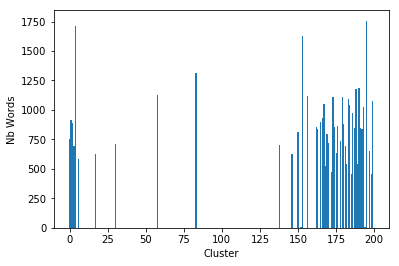

In [146]:
import matplotlib.pyplot as plt
plt.bar(range(len(phrunch_clusters)),[len(val) for val in list(phrunch_clusters.values())])
plt.xlabel('Cluster')
plt.ylabel('Nb Words')
plt.show()

# Is there a network effect ?

In [5]:
import networkx as nx
net_file="/datastore/complexnet/jlevyabi/geoloc/txt_files/network/thresh_5_undirected_mention_net.txt"
G_multi=nx.read_edgelist(net_file,create_using=nx.MultiGraph(),
                         delimiter='\t',data=(('weight',int),),encoding='utf-8',nodetype=str)

## On income

In [51]:
G_full=G_multi.subgraph([str(int(x)) for x in df_inc.usr])
net_data=[]
for node in tqdm(G_full.nodes()):
    for neigh in G_full.neighbors(node):
        if node !=neigh:
            try:
                net_data.append(node,neigh,int(df_inc[df_inc.usr==str(node)]["income"].values[0]-df_inc[df_inc.usr==str(neigh)]["income"].values[0]),
           G_full[node][neigh][0]['weight'])
            except:
                pass

net_data=[(node,neigh,int(df_inc[df_inc.usr==int(node)]["income"].values[0]-
                          df_inc[df_inc.usr==int(neigh)]["income"].values[0]),G_full[node][neigh][0]['weight']) 
          for node in tqdm(G_full.nodes()) for neigh in G_full.neighbors(node) if node !=neigh]
df_net_income_sure=pd.DataFrame(data=net_data,columns=['usr','neigh','income_diff','weight'])


from tqdm import tqdm
dfull_usrs=[str(x) for x in dfull.usr]
G_full=G_multi.subgraph(dfull_usrs)
net_data=[]
for node in tqdm(G_full.nodes()[:2000]):
    for neigh in G_full.neighbors(node):
        if node !=neigh:
            try:
                net_data.append((node,neigh,int(dfull[np.array(dfull_usrs)==node]["income"].values[0]
                                                   -dfull[np.array(dfull_usrs)==neigh]["income"].values[0]),
                                    G_full[node][neigh][0]['weight']))
            except:
                pass

df_net_income_all=pd.DataFrame(data=net_data,columns=['usr','neigh','income_diff','weight'])




  0%|          | 0/784 [00:00<?, ?it/s]/home/jlevyabi/anaconda3/lib/python3.6/site-packages/pandas/core/ops.py:798: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(x, name)(y)



100%|██████████| 784/784 [00:00<00:00, 62112.02it/s]


  0%|          | 0/784 [00:00<?, ?it/s]


 97%|█████████▋| 764/784 [00:00<00:00, 7623.94it/s]


100%|██████████| 784/784 [00:00<00:00, 7629.39it/s]


  0%|          | 0/2000 [00:00<?, ?it/s]


  0%|          | 3/2000 [00:00<02:43, 12.19it/s]


  0%|          | 7/2000 [00:00<02:47, 11.88it/s]


  0%|          | 9/2000 [00:00<02:56, 11.28it/s]


  1%|          | 14/2000 [00:01<03:15, 10.18it/s]


  1%|          | 19/2000 [00:01<02:35, 12.71it/s]


  1%|          | 21/2000 [00:01<03:25,  9.65it/s]


  1%|          | 23/2000 [00:02<05:47,  5.70it/s]


  1%|▏         | 25/2000 [00:02<04:39,  7.06it/s]


  1%|▏         | 27/2000 [00:03<05:16,  6.23it/s]


  2%|▏  

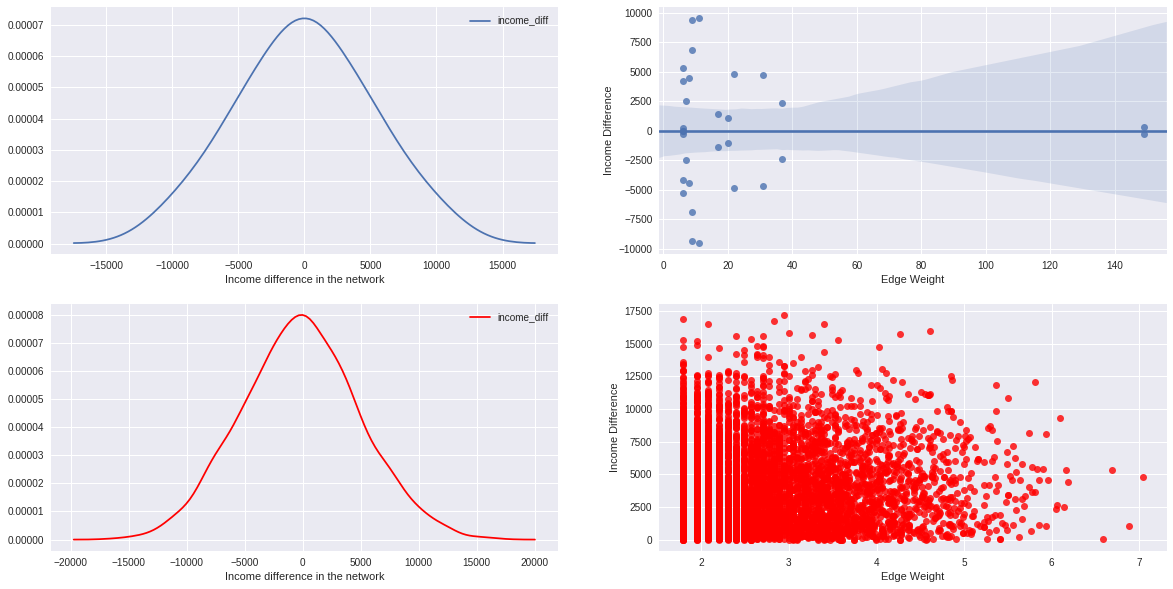

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.plt.figure(figsize=(20,10))
sns.plt.subplot(221)
sns.kdeplot(df_net_income_sure.income_diff)
sns.plt.xlabel('Income difference in the network')

sns.plt.subplot(222)
sns.regplot(x="weight", y="income_diff", data=df_net_income_sure)
sns.plt.xlabel('Edge Weight')
sns.plt.ylabel('Income Difference')


import seaborn as sns
import matplotlib.pyplot as plt
sns.plt.subplot(223)
sns.kdeplot(df_net_income_all.income_diff,color='r')
sns.plt.xlabel('Income difference in the network')

sns.plt.subplot(224)
df_net_income_all['inc_diff_treat']=abs(df_net_income_all['income_diff'])
df_net_income_all['log_weight']=np.log(df_net_income_all['weight'])
ax=sns.regplot(x="log_weight", y="inc_diff_treat", data=df_net_income_all,fit_reg=False,color='r')
#ax.set_xscale('log')
sns.plt.xlabel('Edge Weight')
sns.plt.ylabel('Income Difference')

sns.plt.show()

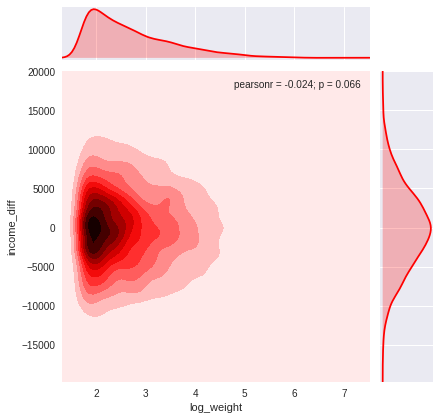

In [58]:
sns.jointplot(x="log_weight", y="income_diff", data=df_net_income, kind="kde",color='r')
sns.plt.show()

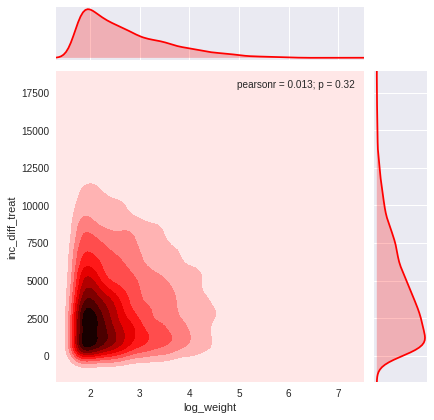

In [59]:
sns.jointplot(x="log_weight", y="inc_diff_treat", data=df_net_income, kind="kde",color='r')
sns.plt.show()

# On location

In [6]:
from geopy.distance import vincenty
from tqdm import tqdm
dfull_usrs=[str(x) for x in dfull.usr]

G_full=G_multi.subgraph([str(int(x)) for x in df_inc.usr])
net_data=[]
for node in tqdm(G_full.nodes()):
    for neigh in G_full.neighbors(node):
        if node !=neigh:
            try:
                net_data.append((node,neigh,
                                 vincenty(tuple(df_inc[df_inc.usr==int(node)][["lat","lon"]].values[0]),
                                          tuple(df_inc[df_inc.usr==int(neigh)][["lat","lon"]].values[0])).km,
                                 G_full[node][neigh][0]['weight']))
            except:
                pass

df_net_geo_sure=pd.DataFrame(data=net_data,columns=['usr','neigh','geo_diff','weight'])    

dfull[np.array(dfull_usrs)==node]["income"]

G_full=G_multi.subgraph(dfull_usrs)
net_data=[]
for node in tqdm(G_full.nodes()[:2000]):
    for neigh in G_full.neighbors(node):
        if node !=neigh:
            try:
                net_data.append((node,neigh,
                                 vincenty(tuple(dfull[np.array(dfull_usrs)==node][["lat","lon"]].values[0]),
                                          tuple(dfull[np.array(dfull_usrs)==neigh][["lat","lon"]].values[0])).km,
                                 G_full[node][neigh][0]['weight']))
            except:
                pass

df_net_geo_all=pd.DataFrame(data=net_data,columns=['usr','neigh','geo_diff','weight'])

100%|██████████| 2000/2000 [03:49<00:00,  8.42it/s]


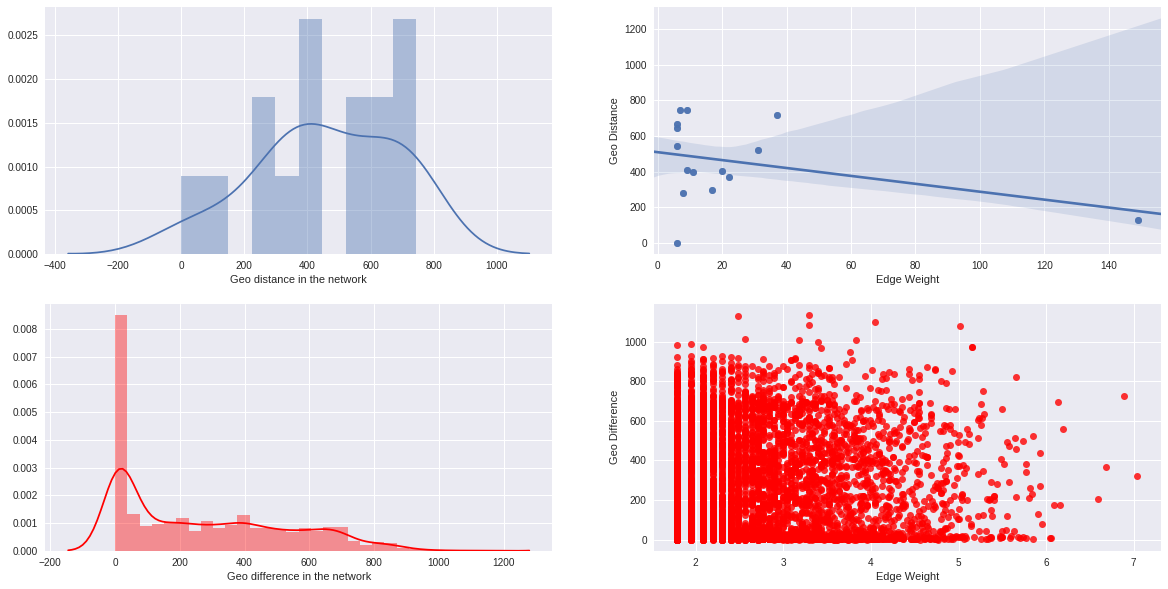

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.plt.figure(figsize=(20,10))
sns.plt.subplot(221)
sns.distplot(df_net_geo_sure.geo_diff,bins=10)
sns.plt.xlabel('Geo distance in the network')

sns.plt.subplot(222)
sns.regplot(x="weight", y="geo_diff", data=df_net_geo_sure)
sns.plt.xlabel('Edge Weight')
sns.plt.ylabel('Geo Distance')

import seaborn as sns
import matplotlib.pyplot as plt
sns.plt.subplot(223)
sns.distplot(df_net_geo_all.geo_diff,color='r',bins=30)
sns.plt.xlabel('Geo difference in the network')
#sns.plt.xscale('log')
#sns.plt.yscale('log')

sns.plt.subplot(224)
df_net_geo_all['geo_diff_treat']=abs(df_net_geo_all['geo_diff'])
df_net_geo_all['log_weight']=np.log(df_net_geo_all['weight'])
ax=sns.regplot(x="log_weight", y="geo_diff_treat", data=df_net_geo_all,fit_reg=False,color='r')
#ax.set_xscale('log')
sns.plt.xlabel('Edge Weight')
sns.plt.ylabel('Geo Difference')

sns.plt.show()

__GRAVITY LAW__

In [74]:
gravity_law_data=np.array([row[1].geo_diff
                           for row in df_net_geo_all.iterrows()])
                           #for wgh in range(row[1]['weight'])])

In [75]:
import collections
def process_and_plot_data(sequence, name, letter):
    estimated_parameters=[]
    #get the distribution
    dict_distrib=collections.Counter(sequence)
    k, Pk = dict_distrib.keys(), dict_distrib.values()
    #reorder the distribution
    k, Pk = (list(t) for t in zip(*sorted(zip(k, Pk))))
    #normalize the distribution
    Pk=np.array(Pk)/float(sum(Pk))
    #plot degree distribution
    d=30
    bins=list(range(d)) #linear bins until 16
    while d<=k[-1]+1:
        bins.append(d)
        d=1.1*d
    Pk_b, k_b = np.histogram(sequence, bins)
    #reorder the distribution
    k_b, Pk_b = (list(t) for t in zip(*sorted(zip(k_b, Pk_b))))
    #normalize the distribution to have frequencies
    Pk_b=np.array(Pk_b)/float(sum(Pk_b))
    #normalize the distribtution per bins
    for i in range(len(k_b)-1):
        Pk_b[i] = float(Pk_b[i])/(np.ceil(k_b[i+1])-np.ceil(k_b[i]))
    Pk_b=Pk_b[:-1]
    k_b=k_b[:-1]
    #plot degree distribution
    return (k_b, Pk_b,)




In [76]:
kb,pkb=process_and_plot_data(gravity_law_data, 'name', 'l')

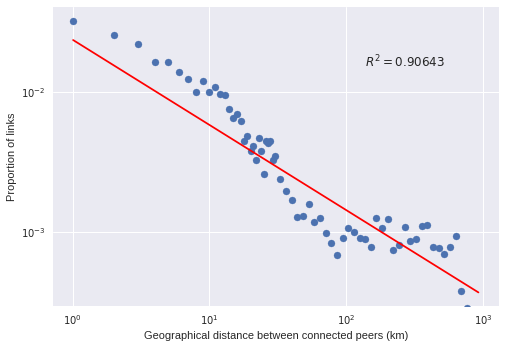

In [78]:
import scipy.stats as st

X=np.array(kb)+0.01
A = np.vstack([np.log10(X), np.ones(len(kb))]).T
m, c = np.linalg.lstsq(A, np.log10(pkb))[0]
sns.plt.plot(X[1:], np.power(10, c) * np.power(X, m)[1:] ,'r')
sns.plt.scatter(X,pkb)
sns.plt.xscale('log')
sns.plt.yscale('log')
sns.plt.xlabel('Geographical distance between connected peers (km)')
sns.plt.ylabel('Proportion of links')
rsquare=(st.spearmanr(pkb[1:], np.power(10, c) * np.power(X, m)[1:])[0]**2)
sns.plt.annotate("$R^2=%.5f$ "%rsquare, xy=(0.7, 0.8), xycoords="axes fraction")
sns.plt.show()

__GRAVITY LAW VERIFIED__